In [1]:
from models import *
from train import *
from plot import *

In [17]:
# model = Siamese(fc_parameters={'input_size': 64})
model = model_kat = Siamese(conv_block_parameters={
    'ch1': 32, 'ch2': 64,
    'conv1_kernel': 3, 'conv2_kernel': 3,
    'use_max_pool1': True, 'max_pool1_kernel': 2, 'max_pool1_stride': 2
}, fc_parameters=
{
    'input_size': 1024, 'fc': 256, 'out': 10,
    'activation1': nn.ReLU(), 'activation2': nn.Softmax(dim=1),
    'use_batch_norm': False
})

In [18]:
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(1000)

In [4]:
print(train_input[0:5].shape)

with torch.no_grad():
    pred_leq, (pred_class1, pred_class2) = model(train_input[0:5])
    print(pred_leq)
    print(pred_class1)
    print(pred_class2)

torch.Size([5, 2, 14, 14])
tensor([[0.4565],
        [0.4400],
        [0.4979],
        [0.5500],
        [0.4343]])
tensor([[0.0000, 0.1989, 0.0000, 0.0000, 0.1261, 0.0000, 1.2447, 0.0000, 0.0000,
         0.0458],
        [0.0000, 0.0539, 0.0000, 0.0000, 0.0000, 0.0000, 1.2707, 1.7978, 0.0000,
         0.2630],
        [0.8790, 0.0000, 1.0637, 0.7477, 0.0000, 0.7483, 0.0000, 0.0000, 1.1273,
         0.0000],
        [0.1154, 0.0796, 0.4146, 0.0000, 0.6582, 0.0000, 0.0000, 0.2805, 0.0000,
         0.0515],
        [0.7235, 0.0000, 0.2376, 0.3951, 0.0000, 0.8730, 0.0000, 0.0000, 0.3291,
         0.0919]])
tensor([[0.1167, 0.1433, 0.0000, 0.2354, 0.0582, 0.0000, 0.3080, 0.5329, 0.0000,
         0.2485],
        [0.1766, 0.0000, 1.9746, 0.5270, 0.2063, 0.0000, 0.0000, 1.0341, 0.7807,
         0.7123],
        [0.2408, 0.0581, 0.6458, 0.3082, 0.2949, 1.0274, 0.0000, 0.0000, 0.6799,
         0.0000],
        [0.2994, 0.6900, 0.0000, 0.1708, 0.2073, 0.1915, 0.8127, 0.0000, 0.0000,
        

In [5]:
summary(model, input_size=(1, 2, 14, 14))

Layer (type:depth-idx)                   Output Shape              Param #
Siamese                                  [1, 1]                    --
├─ConvBlock: 1-1                         [1, 64, 1, 1]             --
│    └─Conv2d: 2-1                       [1, 64, 12, 12]           640
│    └─MaxPool2d: 2-2                    [1, 64, 6, 6]             --
│    └─BatchNorm2d: 2-3                  [1, 64, 6, 6]             128
│    └─ReLU: 2-4                         [1, 64, 6, 6]             --
│    └─Conv2d: 2-5                       [1, 64, 1, 1]             147,520
│    └─BatchNorm2d: 2-6                  [1, 64, 1, 1]             128
│    └─ReLU: 2-7                         [1, 64, 1, 1]             --
├─Flatten: 1-2                           [1, 64]                   --
├─FCBlock: 1-3                           [1, 10]                   --
│    └─Linear: 2-8                       [1, 64]                   4,160
│    └─ReLU: 2-9                         [1, 64]                   --
│   

In [19]:
device = torch.device('cpu') # torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

start = time.perf_counter()
info_cycle = train_model(model,
                            train_input, train_target, train_classes,
                            nb_epochs=25, mini_batch_size=100,
                            criterion_classes=nn.MSELoss(), criterion_leq=nn.MSELoss(),
                            optimizer= None,
                            weight_loss_classes=0.0, weight_loss_pairs=1.0,
                            freeze_epochs=0,
                            one_hot_classes=True, one_hot_leq=False,
                            verbose=False,
                            test_input=test_input, test_target=test_target, test_classes=test_classes,
                            device=device)
end = time.perf_counter()
print(f'Time: {end - start:.2f}s')

Time: 3.85s


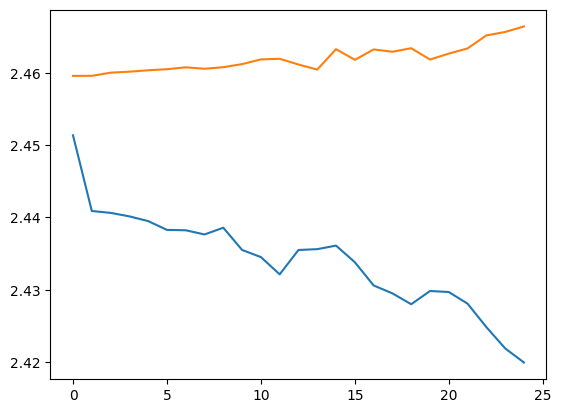

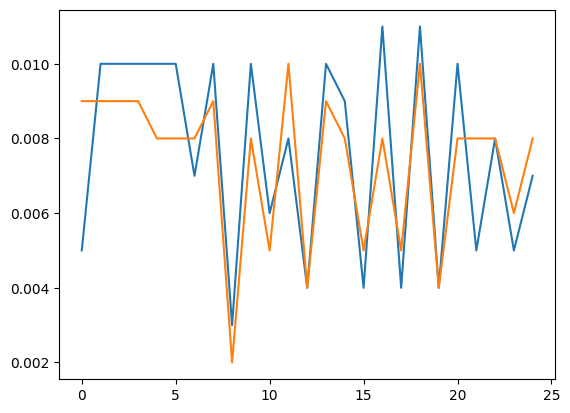

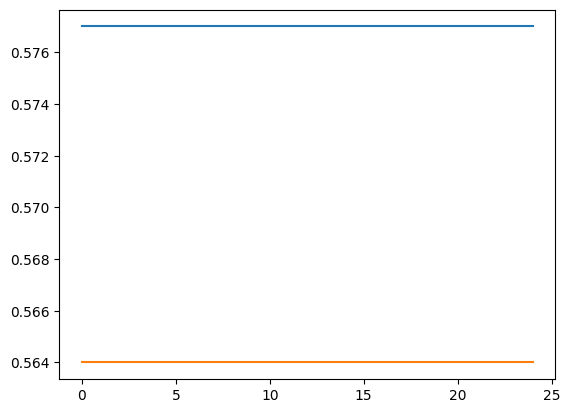

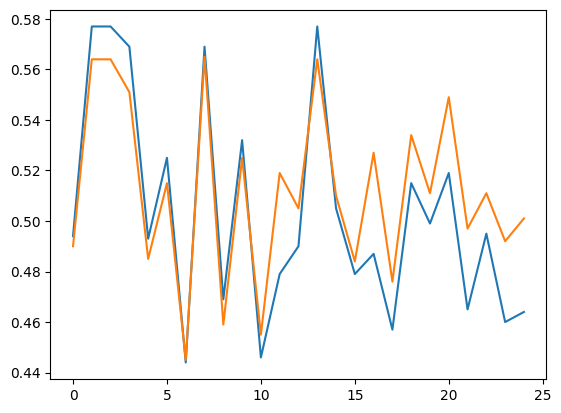

In [20]:
import matplotlib.pyplot as plt

plt.plot(info_cycle['train']['loss'])
plt.plot(info_cycle['test']['loss'])
plt.show()

plt.plot(info_cycle['train']['acc_classes'])
plt.plot(info_cycle['test']['acc_classes'])
plt.show()

plt.plot(info_cycle['train']['acc_leq'])
plt.plot(info_cycle['test']['acc_leq'])
plt.show()

plt.plot(info_cycle['train']['acc_naive'])
plt.plot(info_cycle['test']['acc_naive'])
plt.show()


In [8]:
def mixificator(args1: list[list], args2: list[list], label1) -> list[list]:
    """Mixes the arguments in a list of lists"""
    return [list(x) for x in zip(args1, args2, args3)]

In [9]:
import numpy as np

x = torch.from_numpy(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])).to(torch.float32)
y = torch.from_numpy(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])).to(torch.float32)

crit = nn.CrossEntropyLoss()
crit(x, y)

tensor(19.1141)

In [10]:
# data_target = F.one_hot(train_target, num_classes=2).float()
data_target = F.one_hot(train_target, num_classes=2).float()

In [11]:
data_target.size()

torch.Size([1000, 2])

In [22]:
help(nn.Linear)

Help on class Linear in module torch.nn.modules.linear:

class Linear(torch.nn.modules.module.Module)
 |  Linear(in_features: int, out_features: int, bias: bool = True, device=None, dtype=None) -> None
 |  
 |  Applies a linear transformation to the incoming data: :math:`y = xA^T + b`
 |  
 |  This module supports :ref:`TensorFloat32<tf32_on_ampere>`.
 |  
 |  On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.
 |  
 |  Args:
 |      in_features: size of each input sample
 |      out_features: size of each output sample
 |      bias: If set to ``False``, the layer will not learn an additive bias.
 |          Default: ``True``
 |  
 |  Shape:
 |      - Input: :math:`(*, H_{in})` where :math:`*` means any number of
 |        dimensions including none and :math:`H_{in} = \text{in\_features}`.
 |      - Output: :math:`(*, H_{out})` where all but the last dimension
 |        are the same shape as the input and :math